In [1]:
import os
import pandas as pd
import glob
import numpy as np
from pybedtools import BedTool
from scipy import stats

In [2]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# display plots in this notebook
%matplotlib inline
import re

In [3]:
def Pair2bed(_df_Feature_Loops, _df_Feature_A, Order_of_ID):
    ## Pair to Bed 
    ## for Bedpe, the ID has to be in
    df_Feature_Loops=_df_Feature_Loops
    Feature_Loops=BedTool.from_dataframe(df_Feature_Loops).sort()

    Feature_A =BedTool.from_dataframe(_df_Feature_A).sort()

    Feature_1bin_no_A = Feature_Loops.intersect(Feature_A, v=True)
    df_Feature_1bin_no_A = pd.read_table(Feature_1bin_no_A.fn, header=None)

    Features_2bin_1bin_no_A = BedTool.from_dataframe(df_Feature_1bin_no_A.iloc[:,[3,4,5,0,1,2,Order_of_ID]]).sort()

    Features_no_A = Features_2bin_1bin_no_A.intersect(Feature_A, v=True)
    df_Features_no_A = pd.read_table(Features_no_A.fn, header=None)
    index_with_A = df_Feature_Loops.set_index(df_Feature_Loops.iloc[:,Order_of_ID]).index.difference(df_Features_no_A.iloc[:,Order_of_ID])
    
    df_features_with_A = df_Feature_Loops[df_Feature_Loops.iloc[:,6].isin(index_with_A.values)]

    Features_1bin_A = Feature_Loops.intersect(Feature_A, u=True)
    df_Features_1bin_A = pd.read_table(Features_1bin_A.fn, header=None)
    
    Features_2bin_1bin_A = BedTool.from_dataframe(df_Features_1bin_A.iloc[:,[3,4,5,0,1,2,Order_of_ID]]).sort()

    Features_both_bins_A = Features_2bin_1bin_A.intersect(Feature_A, u=True)

    df_Features_both_bins_A=pd.read_table(Features_both_bins_A.fn, header=None)
    
    index_for_rest = df_Feature_Loops.set_index(df_Feature_Loops.iloc[:,Order_of_ID]).index.difference(df_Features_no_A.iloc[:,6].append(df_Features_both_bins_A.iloc[:,6]))
    df_features_1_A = df_Feature_Loops[df_Feature_Loops.iloc[:,6].isin(index_for_rest.values)]
    return df_Features_both_bins_A, df_Features_no_A, df_features_1_A.iloc[:,0:7]

def box_plot_for_haihui(all_data, y_axis_name):
    ### Define Boxplot FrameSize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.1+len(all_data)*1.2, 4.6))
    x_rotation=-60
    
    plt.xticks(rotation=x_rotation)
    
    ax.boxplot( all_data, showfliers=False, widths=0.3,
           boxprops=dict(linestyle='-', linewidth=1.5, color='black'), 
           whiskerprops = dict(linestyle='-', linewidth=1.5, color='black'),
           capprops = dict(linestyle='-', linewidth=1.5, color='black'),
           medianprops = dict(linestyle='-', linewidth=1.5, color='red'))
    
    ### Generate X ticks
    xtiks = []
    for i in range(len(all_data)):
        xtiks.append(len(all_data[i]))
        
    plt.setp(ax, xticks=[y + 1 for y in range(len(all_data))], xticklabels=xtiks)



    ### plot size
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_label_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='x',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='x',which='minor', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='minor', direction='out', length=6, labelsize=18, width=1.5)

    ax.set_ylabel(y_axis_name, fontsize = 16, fontname="Arial")
    ax.locator_params(nbins=5, axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return None

In [62]:
os.chdir('/home/xli/Data/Haihui/CD8-HP/HiC/HiC_Data_Summary/reps/dump_count_10k/NORM_KR')
chr_set = list(range(1,20,1))+['X', 'Y']
#chr_set = ['10']
RAW_PATH='/home/xli/Data/Haihui/CD8-HP/Summary/'

In [46]:
PATH_FEATURES='/home/xli/Data/Haihui/CD8-HP/Summary/'
# DNase
Path_DNase=PATH_FEATURES+'A_28827_Feature_Union_Naive_DNase_Peaks.bed10'

(2857938, 3)

In [61]:
df_WT16  =pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_16'})
df_WT16.insert(0, '#chr', 'chr'+str(chrs))

AttributeError: type object 'BedTool' has no attribute 'data_Frame'

In [70]:
df_sum_all[df_sum_all.loc[:,['WT_16','DKO_16']].sum(1)!=0].shape

(162889771, 7)

In [71]:
df_sum_all.head(1)

,0,1,WT_16,DKO_16,WT_19,DKO_19,#chr
0,3000000,3000000,754.3243,887.47864,771.83246,237.07726,1


In [ ]:
df_sum_all[df_sum_all.loc[:,['WT_16','DKO_16']].sum(1)!=0].loc[:,['#chr',0,1,'WT_16','DKO_16','WT_19','DKO_19']].to_csv('/home/xli/Data/Haihui/CD8-HP/Analysis_Notebook/162889771_hic_interaction_KR_Norm.bed', sep='\t', index=None)

In [66]:
corr_set=()
df_corr_set=pd.DataFrame()

n_chr=0
df_sum_all = pd.DataFrame()
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_16'})
    df_DKO16 =pd.read_csv('DKO_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_16'})
    df_WT19  =pd.read_csv('WT_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_19'})
    df_DKO19 =pd.read_csv('DKO_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_19'})
    df_sum = df_WT16.merge(df_DKO16, how='outer', on=[0,1]).merge(df_WT19, how='outer', on=[0,1]).merge(df_DKO19, on=[0,1], how='outer')#.drop([0,1],axis=1)
    #df_sum = df_sum[df_sum.values.sum(axis=1) != 0] ## drop all zeros
    df_sum.insert(0, '#chr', str(chrs))
    df_sum_all=df_sum_all.append(df_sum)
    
    
'''
    df_corr_set.loc[n_chr,'chr']='chr'+str(chrs)
    
    for i in range(0+2,4+2):
        for j in range(i+1,4+2):
    #        print (df_sum.columns[i],df_sum.columns[j])
    #        print (df_sum.iloc[:,[i,j]].corr().iloc[0,1])
            COL_NAME=str(df_sum.columns[i])+'_'+str(df_sum.columns[j])
            #print (COL_NAME)
            CORR_VALUE=df_sum.iloc[:,[i,j]].corr().iloc[0,1]
            df_corr_set.loc[n_chr,COL_NAME]=CORR_VALUE
    n_chr+=1
df_corr_set = df_corr_set.set_index('chr')#.describe()
df_corr_set.columns.values
'''

"\n    df_corr_set.loc[n_chr,'chr']='chr'+str(chrs)\n    \n    for i in range(0+2,4+2):\n        for j in range(i+1,4+2):\n    #        print (df_sum.columns[i],df_sum.columns[j])\n    #        print (df_sum.iloc[:,[i,j]].corr().iloc[0,1])\n            COL_NAME=str(df_sum.columns[i])+'_'+str(df_sum.columns[j])\n            #print (COL_NAME)\n            CORR_VALUE=df_sum.iloc[:,[i,j]].corr().iloc[0,1]\n            df_corr_set.loc[n_chr,COL_NAME]=CORR_VALUE\n    n_chr+=1\ndf_corr_set = df_corr_set.set_index('chr')#.describe()\ndf_corr_set.columns.values\n"

In [28]:
#df_sum_all['#chr'] = df_sum_all['#chr'].str.replace('chr','')#
df_sum_all.loc[:,['#chr',0,1,'WT_16','DKO_16','WT_19','DKO_19']].to_csv('/home/xli/Data/Haihui/CD8-HP/Analysis_Notebook/3816850_hic_interaction_KR_Norm.bed', sep='\t', index=None)

In [8]:
# KR matrix
df_sum_all.shape
df_sum_all.to_csv()

(3816850, 6)

In [142]:
df_sum=df_WT16.merge(df_DKO16, how='outer', on=[0,1]).merge(df_WT19, how='outer', on=[0,1]).merge(df_DKO19, on=[0,1], how='outer').replace(np.nan,0)
df_sum.shape

(4550, 6)

In [ ]:
n_chr=0
df_sum_all = pd.DataFrame()
row_sum=[]
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_16'})
    df_DKO16 =pd.read_csv('DKO_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_16'})
    df_WT19  =pd.read_csv('WT_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_19'})
    df_DKO19 =pd.read_csv('DKO_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_19'})
    #df_sum = df_WT16.merge(df_DKO16, how='inner', on=[0,1]).merge(df_WT19, how='inner', on=[0,1]).merge(df_DKO19, on=[0,1], how='inner')#.drop([0,1],axis=1)
    df_sum = df_WT16.merge(df_DKO16, how='outer', on=[0,1]).merge(df_WT19, how='outer', on=[0,1]).merge(df_DKO19, on=[0,1], how='outer').replace(np.nan,0)
    df_sum = df_sum[df_sum.values.sum(axis=1) != 0] ## drop all zeros
    df_sum['distance'] = df_sum[1]-df_sum[0]
    df_sum=df_sum[df_sum['distance'] > 0]
    df_group_inside_chr = df_sum.groupby(0)
    
    for anchor in df_group_inside_chr:
        #print (anchor[0])
        out_row = ['chr'+str(chrs), anchor[0], anchor[0]+10000]+anchor[1].loc[:,['WT_16', 'DKO_16', 'WT_19', 'DKO_19']].sum(axis=0).values.tolist()
        row_sum.append(out_row)

In [ ]:
df_anchor = pd.DataFrame(data=row_sum, columns=['#chr','start','end','WT_16', 'DKO_16', 'WT_19', 'DKO_19'])
Features_Anchor = BedTool.from_dataframe(df_anchor).sort()
df_Tcf1_Peak_Feature = pd.read_csv(RAW_PATH+"B_19042_Feature_Tcf1_WT_CD8_peaks.bed8", sep='\t', header=0)
Feature_Tcf1_Peak = BedTool.from_dataframe(df_Tcf1_Peak_Feature).sort()

Features_Anchor_with_Tcf1 = Features_Anchor.intersect(Feature_Tcf1_Peak, c=True)
df_Anchor_with_Tcf1 = pd.read_csv(Features_Anchor_with_Tcf1.fn,sep='\t', header=None, names=['#chr','start','end','WT_16', 'DKO_16', 'WT_19', 'DKO_19','Tcf1_Number'])

sum_DKO_19 =  df_Anchor_with_Tcf1['DKO_19'].sum()
sum_WT_19 =  df_Anchor_with_Tcf1['WT_19'].sum()
sum_DKO_16 =  df_Anchor_with_Tcf1['DKO_16'].sum()
sum_WT_16 =  df_Anchor_with_Tcf1['WT_16'].sum()

df_Anchor_with_Tcf1['log2_FC_16'] = np.log2( (df_Anchor_with_Tcf1['DKO_16']/sum_DKO_16)/ (df_Anchor_with_Tcf1['WT_16']/sum_WT_16))
df_Anchor_with_Tcf1['log2_FC_19'] = np.log2( (df_Anchor_with_Tcf1['DKO_19']/sum_DKO_19)/ (df_Anchor_with_Tcf1['WT_19']/sum_WT_19))
Feature_Anchor_with_Tcf1 = BedTool.from_dataframe(df_Anchor_with_Tcf1)

In [ ]:
df_Anchor_with_Tcf1['WT'] = df_Anchor_with_Tcf1['WT_16']+df_Anchor_with_Tcf1['WT_19']
df_Anchor_with_Tcf1['DKO'] = df_Anchor_with_Tcf1['DKO_16']+df_Anchor_with_Tcf1['DKO_19']
df_Anchor_with_Tcf1['log2_FC'] = np.log2( (df_Anchor_with_Tcf1['DKO']/(sum_DKO_16+sum_DKO_19)/ (df_Anchor_with_Tcf1['WT']/(sum_WT_16+sum_WT_19))))
df_Anchor_with_Tcf1 = df_Anchor_with_Tcf1.replace(np.nan,0).replace(np.inf,0)

In [ ]:
all_data = [
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']>=3)]['log2_FC_16'],
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']>=1)&(df_Anchor_with_Tcf1['Tcf1_Number']<3)]['log2_FC_16'],
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']==0)]['log2_FC_16']]

#box_plot_for_haihui(all_data, 'Anchor_log2_FC_16')

#'''
all_data = [
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']>=3)]['log2_FC'],
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']>=1)&(df_Anchor_with_Tcf1['Tcf1_Number']<3)]['log2_FC'],
df_Anchor_with_Tcf1[(df_Anchor_with_Tcf1['Tcf1_Number']==0)]['log2_FC']]
box_plot_for_haihui(all_data, 'Anchor_log2_FC')
#'''
#box_plot_for_haihui_no_label(all_data, 'AB_Score_WT_19')
i=0
columns_name = [str(len(all_data[0+i]))+'_#Tcf1_lt_3',
                     str(len(all_data[1+i]))+'_#Tcf1_1~3',
                     str(len(all_data[2+i]))+'_#Tcf1_0']

pvalue=stats.mannwhitneyu(all_data[0], all_data[2], alternative='less')[1]
print('1_vs_3_P_value is: %.1e' % pvalue )
pvalue=stats.mannwhitneyu(all_data[1], all_data[2], alternative='less')[1]
print('2_vs_3_P_value is: %.1e' % pvalue )
print(columns_name)

2310

In [194]:
### Distal and promoter 
Path_2866 ='/home/xli/Data/Haihui/CD8-HP/ChIP_Seq/Tcf1/2866_Tcf1_peaks_with_Tcf7_Core_Motif_hit.bed'
Path_5197 ='/home/xli/Data/Haihui/CD8-HP/ChIP_Seq/Tcf1/5197_Tcf1_peaks_no_Tcf7_3.0_Core_Motif_hit.bed'
PATH_Promoter='/home/xli/Data/Haihui/CD8-HP/Summary/gene_promoter_1k_iv_unique.bed'

Feature_2866 = BedTool(Path_2866).sort()
Feature_5197 = BedTool(Path_5197).sort()
Feature_Promoter=BedTool(PATH_Promoter).sort()

Feature_Anchor_with_Tcf1_on_promoter = Feature_Anchor_with_Tcf1.intersect(Feature_2866.intersect(Feature_Promoter, v=True), u=True)
#Feature_Anchor_with_Tcf1_on_promoter = Feature_Anchor_with_Tcf1.intersect(Feature_5197.intersect(Feature_Promoter, v=True), u=True)

df_Anchor_with_Tcf1_on_promoter = pd.read_csv(Feature_Anchor_with_Tcf1_on_promoter.fn, sep='\t', header=None, names=df_Anchor_with_Tcf1.columns)
df_Anchor_with_Tcf1_on_promoter.shape

(2350, 10)

1_vs_3 P_value is: 1.9e-09 _None_Promoter_Motif+_2310
['214_#Tcf1_lt_3', '2136_#Tcf1_1~3', '0_#Tcf1_0']


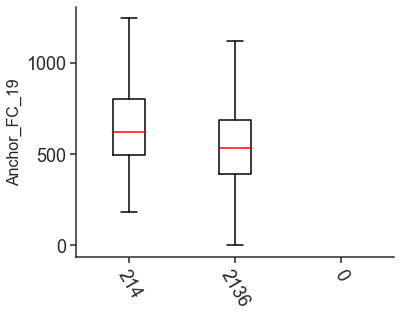

In [195]:
all_data = [
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']>=3)]['WT_19'],
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']>=1)&(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']<3)]['WT_19'],
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']==0)]['WT_19']]

box_plot_for_haihui(all_data, 'Anchor_FC_19')

'''
all_data = [
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']>=3)]['log2_FC_19'],
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']>=1)&(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']<3)]['log2_FC_19'],
df_Anchor_with_Tcf1_on_promoter[(df_Anchor_with_Tcf1_on_promoter['Tcf1_Number']==0)]['log2_FC_19']]
box_plot_for_haihui(all_data, 'Anchor_log2_FC_19')
box_plot_for_haihui_no_label(all_data, 'AB_Score_WT_19')
'''
i=0
columns_name = [str(len(all_data[0+i]))+'_#Tcf1_lt_3',
                     str(len(all_data[1+i]))+'_#Tcf1_1~3',
                     str(len(all_data[2+i]))+'_#Tcf1_0']

pvalue=stats.mannwhitneyu(all_data[0], all_data[1], alternative='greater')[1]
print('1_vs_3 P_value is: %.1e' % pvalue + " _None_Promoter_Motif+_2310" )
#pvalue=stats.mannwhitneyu(all_data[1], all_data[2], alternative='greater')[1]
#print('2_vs_3 P_value is: %.1e' % pvalue + " _None_Promoter_Motif+_2310" )

print(columns_name)

In [92]:
print( sum_DKO_19)
print (sum_WT_19)

26072082.0
31030569.0


In [24]:
pvalue=stats.mannwhitneyu(all_data[0], all_data[2], alternative='less')[1]
print('P_value is: %.1e' % pvalue )

P_value is: 1.5e-01


(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

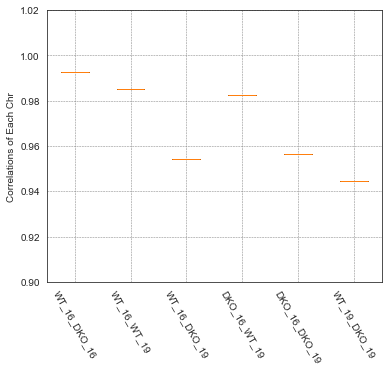

In [38]:
all_data = [df_corr_set.iloc[:,0],df_corr_set.iloc[:,1],df_corr_set.iloc[:,2],df_corr_set.iloc[:,3],
            df_corr_set.iloc[:,4],df_corr_set.iloc[:,5]]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axes.boxplot( all_data, showfliers=True)#,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)

axes.set_ylabel('Correlations of Each Chr')
axes.set_ylim(0.9, 1.02)
i=0
plt.setp( axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=df_corr_set.columns.values)
plt.xticks(rotation=-60)

In [40]:
df_sum_all = pd.DataFrame()
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_16'})
    df_DKO16 =pd.read_csv('DKO_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_16'})
    df_WT19  =pd.read_csv('WT_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'WT_19'})
    df_DKO19 =pd.read_csv('DKO_CD8_2019_chr'+str(chrs)+'.txt', header=None, sep="\t").rename(columns={2:'DKO_19'})
    df_sum = df_WT16.merge(df_DKO16, how='inner', on=[0,1]).merge(df_WT19, how='inner', on=[0,1]).merge(df_DKO19, on=[0,1], how='inner')
    df_sum = df_sum[df_sum.iloc[:,2:].values.sum(axis=1) != 0] ## drop all zeros
    df_sum['#chr'] = 'chr'+str(chrs)
    df_sum_all = df_sum_all.append(df_sum)

RAW_PATH='/home/xli/Data/Haihui/CD8-HP/Summary/'

#Feature_Interaction = BedTool.from_dataframe(df_sum_all.loc[:,['#chr', 0, 1, 'WT_16', 'DKO_16', 'WT_19', 'DKO_19']]).sort()


In [41]:
df_Tcf1_Motif_Feature = pd.read_csv(RAW_PATH+"B_Tcf7_Core_Motif_hits.bed", sep='\t', header=None)
Feature_Tcf1_Motif = BedTool.from_dataframe(df_Tcf1_Motif_Feature).sort()
df_Tcf1_Peak_Feature = pd.read_csv(RAW_PATH+"B_19042_Feature_Tcf1_WT_CD8_peaks.bed8", sep='\t', header=0)
Feature_Tcf1_Peak = BedTool.from_dataframe(df_Tcf1_Peak_Feature).sort()
PATH_GENE_Promoter=RAW_PATH+'gene_promoter_1k_iv_unique.bed'
FEATURE_PROMOTER=BedTool(PATH_GENE_Promoter)
FEATURE_Tcf1_Distal=Feature_Tcf1_Peak.intersect(FEATURE_PROMOTER, v=True)
FEATURE_Tcf1_Distal.head(1)
df_Tcf1_Distal = pd.read_csv(FEATURE_Tcf1_Distal.fn, sep="\t", header=None)

chr1	7085992	7086395	Tcf1_6	4.98577	.	7086096	4.98577
 

In [46]:
df_test = df_sum_all.reset_index().drop('index',axis=1).reset_index()
resolution=int(10000/2)
df_test.loc[:,'x1']=df_test.loc[:,0].astype(int)-resolution
df_test.loc[:,'x2']=df_test.loc[:,0].astype(int)+resolution
df_test.loc[:,'y1']=df_test.loc[:,1].astype(int)-resolution
df_test.loc[:,'y2']=df_test.loc[:,1].astype(int)+resolution
df_test = df_test.loc[:,['#chr', 'x1', 'x2', '#chr', 'y1','y2', 'index','WT_16', 'DKO_16', 'WT_19', 'DKO_19']]
df_test['Diff_PET'] = df_test['DKO_16']- df_test['WT_16']

df_test.head(1)

,#chr,x1,x2,#chr,y1,y2,index,WT_16,DKO_16,WT_19,DKO_19,Diff_PET
0,chr10,2995000,3005000,chr10,2995000,3005000,0,509.4887,634.2135,801.1735,297.73517,124.7248


In [49]:
df_TT, df_T_NT, df_NT_NT =Pair2bed(df_test[df_test.loc[:,'x1']>=0], df_Tcf1_Distal, 6)
df_TT.head(1)

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,0,1,2,3,4,5,6
0,chr10,3345000,3355000,chr10,3345000,3355000,310


In [50]:
df_TT = df_TT.loc[:,[6]].merge(df_test, left_on=6, right_on='index', how='inner')
df_T_NT = df_T_NT.loc[:,[6]].merge(df_test, left_on=6, right_on='index', how='inner')
df_NT_NT = df_NT_NT.loc[:,['index']].merge(df_test, on='index', how='inner')
df_TT.head(1)

,6,#chr,x1,x2,#chr,y1,y2,index,WT_16,DKO_16,WT_19,DKO_19,Diff_PET
0,310,chr10,3345000,3355000,chr10,3345000,3355000,310,327.9623,314.1544,426.79953,126.60133,-13.8079


P_value is: 5.0e-01


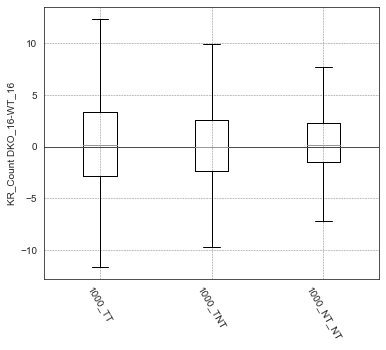

In [56]:
import re

all_data = [df_TT.sample(1000)['Diff_PET'],
            df_T_NT.sample(1000)['Diff_PET'],
            df_NT_NT.sample(1000)['Diff_PET']]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axes.boxplot( all_data, showfliers=False)#,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)

axes.set_ylabel('KR_Count DKO_16-WT_16')
#axes.set_ylim(-2.5,2.5)
i=0
plt.setp( axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=[ str(len(all_data[0+i]))+'_TT',
                      str(len(all_data[1+i]))+'_TNT',
                     str(len(all_data[2+i]))+'_NT_NT'])
#                     str(len(all_data[3+i]))+'_All'])
plt.xticks(rotation=-60)


from scipy import stats
MWU, pvalue = ( stats.mannwhitneyu(all_data[0], all_data[1], alternative=None )[0], 
                stats.mannwhitneyu(all_data[0], all_data[1], alternative='two-sided')[1])

if float("%.1e" % pvalue) == 1.0:
    plt.text(0.1, r'p = 1.0', fontsize=15)
    print('P_value is: %.1e' % pvalue )
else:
    if pvalue !=0:
        sign = '='
        digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
        print('P_value is: %.1e' % pvalue )
        #plt.text( 1.0, (3.7) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
    else:
        sign, digit, exp = '<', '1.0', '-300'
        print('P_value is: %.1e' % pvalue )
        #plt.text( 1.1, (13) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
plt.axhline(y=0, linewidth=1, color='r')


In [211]:
corr_set=()
df_corr_set=pd.DataFrame()

n_chr=0
df_sum_all = pd.DataFrame()
for chrs in chr_set:
    #print (chrs)
    df_WT16  =pd.read_csv('chr'+str(chrs)+'_WT_16.txt', header=None).rename(columns={0:'WT_16'})
    df_DKO16 =pd.read_csv('chr'+str(chrs)+'_DKO_16.txt', header=None).rename(columns={0:'DKO_16'})
    df_WT19  =pd.read_csv('chr'+str(chrs)+'_WT_19.txt', header=None).rename(columns={0:'WT_19'})
    df_DKO19 =pd.read_csv('chr'+str(chrs)+'_DKO_19.txt', header=None).rename(columns={0:'DKO_19'})
    df_sum = pd.concat([df_WT16,df_DKO16,df_WT19,df_DKO19],axis=1)
    df_sum = df_sum[df_sum.values.sum(axis=1) != 0] ## drop all zeros
    df_sum_all=df_sum_all.append(df_sum)
    df_corr_set.loc[n_chr,'chr']='chr'+str(chrs)
    for i in range(0,4):
        for j in range(i+1,4):
    #        print (df_sum.columns[i],df_sum.columns[j])
    #        print (df_sum.iloc[:,[i,j]].corr().iloc[0,1])
            COL_NAME=df_sum.columns[i]+'_'+df_sum.columns[j]
            CORR_VALUE=df_sum.iloc[:,[i,j]].corr().iloc[0,1]
            df_corr_set.loc[n_chr,COL_NAME]=CORR_VALUE
            
    n_chr+=1
df_corr_set = df_corr_set.set_index('chr')#.describe()
df_corr_set.columns.values

array(['WT_16_DKO_16', 'WT_16_WT_19', 'WT_16_DKO_19', 'DKO_16_WT_19',
       'DKO_16_DKO_19', 'WT_19_DKO_19'], dtype=object)

In [29]:
# chunksize test
df_chunk = pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t", chunksize=1000000)

#def filtered_long_range(df_interaction, max_distance):
    
for chunk in df_chunk:
    type(chunk)
    break
    
chunk_list = []  # append each chunk df here 
df_chunk = pd.read_csv('WT_CD8_2016_chr'+str(chrs)+'.txt', header=None, sep="\t", chunksize=100000)
for chunk in df_chunk:  
    # perform data filtering 
    chunk_filter = chunk_preprocessing(chunk)
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
df_concat = pd.concat(chunk_list)

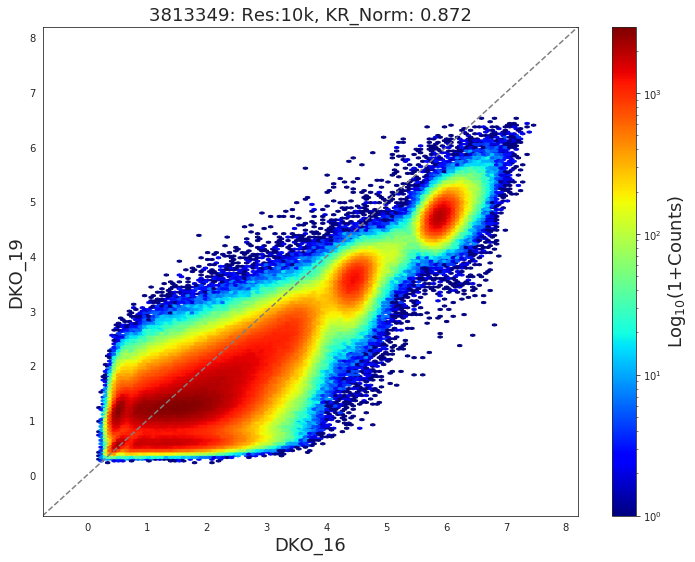

In [110]:
def hexbin_with_density(df, highlight_name, title_name, density_scale, drop_top_outlier):
    ### drop outlier
    df = df.drop(df.iloc[:,0].nlargest(n=drop_top_outlier,keep='first').index)
    
    
    range_limit=df.max().max()
    range_limit_min=df.min().min()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9), sharex=False, sharey=False)
    
    if density_scale == 'log':
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100),mincnt=range_limit_min, cmap=plt.cm.jet, bins='log', alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Log$_{10}$(1+Counts)', fontsize=18)
    else:
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100),mincnt=range_limit_min, cmap=plt.cm.jet,
                   alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Counts', fontsize=18)

    ###  highlight a point
    if len(highlight_name) >= 1:
        for highlight_index in highlight_name[:]:
            ax.scatter(df[df.index == highlight_index].iloc[:,[0]],
                        df[df.index == highlight_index].iloc[:,[1]],
                        alpha=1.0,s=50,color='red', label=highlight_index,edgecolor='red')
            ax.text(df[df.index == highlight_index].iloc[:,0]-range_limit/20.0,
                      df[df.index == highlight_index].iloc[:,1]+range_limit/25.0, highlight_index, fontsize=16, color='r')


    ax.yaxis.grid(False)
    ax.set_ylim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlabel(str(df.columns[0]), fontsize=18)
    ax.set_ylabel(str(df.columns[1]), fontsize=18)
    ax.plot([-0.1*range_limit,range_limit+0.1*range_limit], [-0.1*range_limit, range_limit+0.1*range_limit], ls="--", c="gray")
    ax.set_title(str(len(df))+ ': '+ title_name , fontsize=18)
    return 0

#df_plot=df_sum_all.loc[:,['WT_16', 'DKO_16']].dropna()
df_plot=np.log(1+df_sum_all.loc[:,['DKO_16', 'DKO_19']].dropna())
#df_plot=df_plot.iloc[0:316850]
aa = hexbin_with_density(df_plot, '', 'Res:10k, KR_Norm: ' + str("{:.3f}".format(df_plot.corr().iloc[0,1])), 'log',0)

Text(0.5, 0, '')

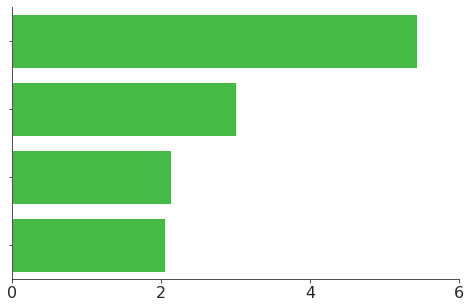

In [194]:
import seaborn as sns
import numpy as np

tips = sns.load_dataset("tips")
tips
pvalue=[3.64*10**-6,9.77*10**-4,7.26*10**-3,8.73*10**-3]
log_pvalue = -np.log10(pvalue)
df= pd.DataFrame(data=log_pvalue)

sns.set_style("ticks")

plt.figure(figsize=(8,5))

ax = sns.barplot(x=0, y=df.index, data=df,orient='h', color='limegreen')

plt.xticks(fontsize= 16)

ax.set_yticklabels([])
#ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,6)

ax.set_xticks((0,2,4,6)) 
#ax.axes.get_xaxis().set_ticklabels([])
plt.xlabel('')